# Snow Analysis
### Purpose
This notebook will look at volunteer trends for reporting snow, adressing the Github issue #54  
(this notebook is a copy of the rain analysis notebook, but with `%s/rain/snow/g`)

### Author: 
Hamza El-Saawy
### Date: 
2020-08-10
### Update Date: 
2020-08-10

### Inputs 
 - `1.3-rec-connecting-fips-ecosystem-data.txt`

### Output Files
None

## Steps or Proceedures in the notebook 
 - Clean the CBC ecological data 
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
n/a

## Notes
In addition to considerations from the rain analysis notebook, this notebook looks only at snowfall (`am/pm_snow` for volunteers and `snow` for GHCN) and not snowdepth (`min/max_snow` for volunteers and `snwd` for GHCN) as the latter will likely be highly location, ecosystem, and elevation dependant.  
Additionally, it is unclear if volunteers are being asked to measure the snowdepth during the shift or the amount of snow that was on the ground when they arrived/left.

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import scipy.stats as stats

In [15]:
import sklearn.metrics as metrics

In [16]:
sns.set(style="darkgrid")

In [17]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

In [18]:
#
# 
#

# drop all stations farther than this threshold (meters)
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# drop all stations farther than this threshold (meters) in elevation
#  the farthest is 3.5km, with the mean being 70m and median being 23m
ELEVATION_THRESHOLD = 50

# consider stations to consense on a snow value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around 1/2: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

In [19]:
DATA_PATH = '../data/Cloud_Data'
ECO_DATA_PATH =  os.path.join(DATA_PATH, '1.3-rec-connecting-fips-ecosystem-data.txt')

In [20]:
eco_data = pd.read_csv(ECO_DATA_PATH, encoding = "ISO-8859-1", sep="\t", compression = "gzip")
eco_data = eco_data.rename(columns={'circle_name': 'c_name', 
                                    'circle_id': 'c_id',
                                    'lat': 'c_lat', 
                                    'lon': 'c_lon', 
                                    'circle_elev': 'c_elev',
                                    'Ecosys_circle': 'c_ecosys', 
                                    'Nlcd_code_circle': 'c_nlcdcode',
                                    'id': 's_id', 
                                    'latitude': 's_lat', 
                                    'longitude': 's_lon', 
                                    'elevation': 's_elev',
                                    'Ecosys_station': 's_ecosys', 
                                    'Nlcd_code_station': 's_nlcdcode',})

In [21]:
# Drop all the other data that wont be needed
prcp_data = eco_data.loc[:, ['count_date', 'c_name', 'ui','country_state', 'c_id', 'c_lat', 'c_lon',
                              'am_snow', 'pm_snow', 'c_elev', 'c_ecosys', 'c_nlcdcode',
                              's_id', 's_lat', 's_lon', 's_elev', 's_ecosys', 's_nlcdcode','snow',
                             ]]

In [22]:
# Observe the Size of the data frame
eco_data.shape

(756378, 78)

In [23]:
# Observe the number of unique circles in the dataframe 
eco_data['ui'].nunique()

80765

In [24]:
eco_data.head()

,c_name,country_state,c_lat,c_lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,...,block_fips,county_fips,c_ecosys,Usgsid_sys_circle,c_nlcdcode,Nlcd_circle,s_ecosys,Usgsid_sys_station,s_nlcdcode,Nlcd_station
0,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1955,1955-01-01,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1956,1955-12-31,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hawai'i: Volcano N.P.,US-HI,19.4333,-155.2833,1968,1967-12-30,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Prep

#### Stations Reporting Snow

In [25]:
# Create the field s_snow which is True if the row has a value of snow 
# greater than 0 (an indicator that it snowed) and is NA otherwise

# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_snow'] = np.where(prcp_data.snow.isna(), pd.NA, prcp_data.snow > 0)

#### Volunteer records on snow data

`[am|pm]_snow` are strings containing `1`:`4`, for heavy, light, none, or unknow snow.  
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day.   
If both am and pm are `3`, then there was no precipitation that day.  
Else, we mark `nan`

In [26]:
for c in ['am_snow', 'pm_snow']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [27]:
# Use Regex to find the rows that contain a "1" and/or "2". 
# If those values are recorded set the value of c_snow to True
# If a "3" is recorded set c_snow to False

prcp_data['c_snow'] = pd.NA

prcp_data.loc[(prcp_data.am_snow.str.contains('[12]', na=False) | prcp_data.pm_snow.str.contains('[12]', na=False)), 'c_snow'] = True
prcp_data.loc[((prcp_data.am_snow == '3') & (prcp_data.pm_snow == '3')), 'c_snow'] = False

## Comparing stations and circles
1. Calulate the distance between the station and the circle. Field is 'distance' 
2. Calulate the absolute change in elivation between the station and the circle. Field is 'd_elev'
3. Calulate if station and circle share ecosystem. Fields 'same_ecosys' and 'same_nlcd'

In [28]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

In [29]:
prcp_data['d_elev'] = np.abs(prcp_data.s_elev - prcp_data.c_elev)

In [30]:
# convert to int array to get nullable boolean arrays
#  https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html#kleene-logical-operations
prcp_data['same_ecosys'] = prcp_data.c_ecosys.astype('Int64') == prcp_data.s_ecosys.astype('Int64')
prcp_data['same_nlcd'] = prcp_data.c_nlcdcode.astype('Int64') == prcp_data.s_nlcdcode.astype('Int64')

## Apply Data Limits on Elevation and Distance and Prep for Analysis 
1. Drop rows where the circle and the station are too far away from each other in either distance or elivation
2. Remove columns we dont need
3. Sort the dataset by circle then station

In [31]:
# drop everything outside of the distance or elevation threshold
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)
prcp_data.drop(prcp_data[prcp_data.d_elev > ELEVATION_THRESHOLD].index, inplace=True)

In [32]:
# once again dump excess data
prcp_data.drop(columns=['am_snow', 'pm_snow','c_elev', 'c_ecosys', 'c_nlcdcode', 
                        's_elev', 's_ecosys', 's_nlcdcode','snow',], inplace=True)

In [33]:
# isolate only the circle specific volunteer data
circle_obs = prcp_data[['count_date', 'c_name', 'ui','country_state', 
                        'c_id', 'c_lat', 'c_lon','c_snow' , 'c_snow_min', 'c_snow_max']].groupby(['c_id', 'count_date']).agg('first')

In [34]:
# sort by circle then station information
prcp_data = prcp_data.set_index(['c_id', 'count_date', 's_id']).sort_index()

In [35]:
prcp_data.head(50)

c_name                     ui  \
c_id    count_date s_id                                                 
87ymwsn 1968-12-26 USC00519130  Kaua'i: Waimea  22.0833-159.6667_1969   
87ysunb 1971-12-27 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1972   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1972   
        1972-12-17 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1973   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1973   
        1973-12-16 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00518217  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00518570  Kaua'i: Lihu'e  21.9667-159.4333_1974   
                   USC00518573  Kaua'i: Lihu'e  21.9667-159.4333_1974   
        1974-12-15 US1HIKI0004  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   US1HIKI0014  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   US1HIKI0018  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00510006  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00510456  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00511038  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00513023  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00514746  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00515464  Kaua'i: Lihu'e  21.9667-159.4333_1975   
                   USC00517777  Kaua'i: Lihu'e  21.9667-159.4333_1975   

                               country_state    c_lat     c_lon    s_lat  \
c_id    count_date s_id                                                    
87ymwsn 1968-12-26 USC00519130         US-HI  22.0833 -159.6667  22.1167   
87ysunb 1971-12

In [36]:
prcp_data.shape

(412105, 13)

# Snow Analysis

In [37]:
g = prcp_data.groupby(level=['c_id', 'count_date'])

In [38]:
g.head()

c_name                        ui  \
c_id    count_date s_id                                                     
87ymwsn 1968-12-26 USC00519130   Kaua'i: Waimea     22.0833-159.6667_1969   
87ysunb 1971-12-27 US1HIKI0004   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   US1HIKI0014   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   US1HIKI0018   Kaua'i: Lihu'e     21.9667-159.4333_1972   
                   USC00510006   Kaua'i: Lihu'e     21.9667-159.4333_1972   
...                                         ...                       ...   
zcpkrwz 1979-12-18 USW00045702  Amchitka Island  51.409713179.284881_1980   
        1992-12-20 USC00500252  Amchitka Island  51.409713179.284881_1993   
                   USW00045702  Amchitka Island  51.409713179.284881_1993   
        1993-12-28 USC00500252  Amchitka Island  51.409713179.284881_1994   
                   USW00045702  Amchitka Island  51.409713179.284881_1994   

                               country_state      c_lat       c_lon    s_lat  \
c_id    count_date s_id                                                        
87ymwsn 1968-12-26 USC00519130         US-HI  22.083300 -159.666700  22.1167   
87ysunb 1971-12-27 US1HIKI0004         US-HI  21.966700 -159.433300  21.9249   
                   US1HIKI0014         US-HI  21.966700 -159.433300  21.9055   
                   US1HIKI0018         US-HI  21.966700 -159.433300  21.9075   
                   USC00510006         US-HI  21.966700 -159.433300  21.9500   
...                                      ...        ...         ...      ...   
zcpkrwz 1979-12-18 USW00045702         US-AK  51.409713  179.284881  51.3833   
        1992-12-20 USC00500252         US-AK  51.409713  179.284881  51.3833   
                   USW00045702         US-AK  51.409713  179.284881  51.3833   
        1993-12-28 USC00500252         US-AK  51.409713  179.284881  51.3833   
                   USW00045702         US-AK  51.409713  179.284881  51.3833   

                                   s_lon s_snow c_snow      distance  d_elev  \
c_id    count_date s_id                                                        
87ymwsn 1968-12-26 USC00519130 -159.6167   <NA>   <NA>   6352.278644   36.16   
87ysunb 1971-12-27 US1HIKI0004 -159.4983   <NA>   <NA>   8159.889753   43.84   
                   US1HIKI0014 -159.5150   <NA>   <NA>  10834.614107   11.26   
                   US1HIKI0018 -159.5181   <NA>   <NA>  10950.027151   17.34   
                   USC00510006 -159.4333   <NA>   <NA>   1857.479921   35.96   
...                                  ...    ...    ...           ...     ...   
zcpkrwz 1979-12-18 USW00045702  179.2500   <NA>   True   3806.612762     NaN   
        1992-12-20 USC00500252  179.2833  False   <NA>   2939.869435     NaN   
                   USW00045702  179.2500   <NA>   <NA>   3806.612762     NaN   
        1993-12-28 USC00500252  179.2833   <NA>   <NA>   2939.869435     NaN   
                   USW00045702  179.2500   <NA>   <NA>   3806.612762     NaN   

                                same_ecosys  same_nlcd  
c_id    count_date s_id                                 
87ymwsn 1968-12-26 USC00519130         <NA>       <NA>  
87ysunb 1971-12-27 US1HIKI0004         <NA>       <NA>  
                   US1HIKI0014         <NA>       <NA>  
                   US1HIKI0018         <NA>       <NA>  
                   USC00510006         <NA>       <NA>  
...                                     ...        ...  
zcpkrwz 1979-12-18 USW00045702         <NA>       <NA>  
        1992-12-20 USC00500252         <NA>       <NA>  
                   USW00045702         <NA>       <NA>  
        1993-12-28 USC00500252         <NA>       <NA>  
                   USW00045702         <NA>       <NA>  

[218997 rows x 13 columns]

In [39]:
def snow_calc(dfg):
    is_na = dfg.s_snow.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_snow.size + 0
    num_notna = dfg.s_snow.count() + 0
    num_true = dfg.s_snow.sum() + 0
    
    e = dfg.loc[dfg.same_ecosys, 's_snow']
    e_num = e.size + 0
    e_num_notna = e.count() + 0
    e_num_true = e.sum() + 0
    
    n = dfg.loc[dfg.same_nlcd, 's_snow']
    n_num = n.size + 0
    n_num_notna = n.count() + 0
    n_num_true = n.sum() + 0
    
    # havent figured out how to inlinse this yet ...
    lowest_id = dfg.d_elev.idxmin() if (num > 0) else np.NaN
    lowest_id_na = dfg.loc[~is_na, 'd_elev'].idxmin() if (num_notna > 0) else np.NaN
    
    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,
        
        'e_num' : e_num,
        'e_num_notna' : e_num_notna,
        'e_num_true' : e_num_true,
        
        'n_num' : n_num,
        'n_num_notna' : n_num_notna,
        'n_num_true' : n_num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
        'e_p' : e_num_true / e_num_notna if (e_num_notna > 0) else np.NaN,
        'n_p' : n_num_true / n_num_notna if (n_num_notna > 0) else np.NaN,
        
        'snow_closest' : dfg.loc[dfg.distance.idxmin(), 's_snow'] if (num > 0) else pd.NA,
        'snow_closest_notna' : dfg.loc[dfg.loc[~is_na, 'distance'].idxmin(), 's_snow'] if (num_notna > 0) else pd.NA,
        
        'snow_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 's_snow'],
        'snow_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 's_snow'],
    })


# The new fields used for Analysis
num - The number of stations for a circle for a count date

num_notna - The number of stations that are not null for their snow measurment 

num_true - The number of stations that reported true for snow

The next sections for "e_" and "n_" are the same as abouve, except e is only stations for a circle that
are in the same ecosystem and n is stations with the same nlcd code.

p - The proportion of stations that reported snow for a circle



In [40]:
# Compute the fields used for Analysis
circle_data = g.apply(snow_calc)

In [41]:
# Add in the circles details (Name, State, Lat, Lon)
circle_data = circle_obs.join(circle_data)

# Determine if there is Consensus amoung a Circle's Reference Stations
Using the AGREEMENT_THRESHOLD set at the top of the notebook, determine if the there are enough stations for
a circle agree that it rained based on that agreement threshold.

Do this for all stations and stations within the same ecosys and nlcd code 

In [42]:
# if the stations couldnt agree (p ∈ [1-AGREEMENT_THRESHOLD, AGREEMENT_THRESHOLD]) or p is NaN, set the consenus to NaN as well
circle_data['consensus'] = np.where(((circle_data.p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.p <= AGREEMENT_THRESHOLD)) | circle_data.p.isna(), 
                                     pd.NA, circle_data.p >= AGREEMENT_THRESHOLD)

circle_data['e_consensus'] = np.where(((circle_data.e_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.e_p <= AGREEMENT_THRESHOLD)) | circle_data.e_p.isna(), 
                                     pd.NA, circle_data.e_p >= AGREEMENT_THRESHOLD)

circle_data['n_consensus'] = np.where(((circle_data.n_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.n_p <= AGREEMENT_THRESHOLD)) | circle_data.n_p.isna(), 
                                     pd.NA, circle_data.n_p >= AGREEMENT_THRESHOLD)

In [43]:
for c in ['consensus', 'e_consensus', 'n_consensus', 'snow_closest', 'snow_closest_notna', 'snow_lowest', 'snow_lowest_notna']:
    circle_data[c] = circle_data[c].astype('boolean')

In [44]:
circle_data.head()

c_name                     ui country_state  \
c_id    count_date                                                        
87ymwsn 1968-12-26  Kaua'i: Waimea  22.0833-159.6667_1969         US-HI   
87ysunb 1971-12-27  Kaua'i: Lihu'e  21.9667-159.4333_1972         US-HI   
        1972-12-17  Kaua'i: Lihu'e  21.9667-159.4333_1973         US-HI   
        1973-12-16  Kaua'i: Lihu'e  21.9667-159.4333_1974         US-HI   
        1974-12-15  Kaua'i: Lihu'e  21.9667-159.4333_1975         US-HI   

                      c_lat     c_lon c_snow  num  num_notna  num_true  e_num  \
c_id    count_date                                                              
87ymwsn 1968-12-26  22.0833 -159.6667    NaN    1          0         0      0   
87ysunb 1971-12-27  21.9667 -159.4333    NaN   13          3         0      0   
        1972-12-17  21.9667 -159.4333    NaN   13          4         0      0   
        1973-12-16  21.9667 -159.4333    NaN   13          4         0      0   
        1974-12-15  21.9667 -159.4333    NaN   13          3         0      0   

                    ...    p  e_p  n_p  snow_closest  snow_closest_notna  \
c_id    count_date  ...                                                    
87ymwsn 1968-12-26  ...  NaN  NaN  NaN          <NA>                <NA>   
87ysunb 1971-12-27  ...  0.0  NaN  NaN         False               False   
        1972-12-17  ...  0.0  NaN  NaN         False               False   
        1973-12-16  ...  0.0  NaN  NaN         False               False   
        1974-12-15  ...  0.0  NaN  NaN         False               False   

                    snow_lowest  snow_lowest_notna  consensus  e_consensus  \
c_id    count_date                                                           
87ymwsn 1968-12-26         <NA>               <NA>       <NA>         <NA>   
87ysunb 1971-12-27        False              False      False         <NA>   
        1972-12-17        False              False      False         <NA>   
        1973-12-16        False              False      False         <NA>   
        1974-12-15        False              False      False         <NA>   

                    n_consensus  
c_id    count_date               
87ymwsn 1968-12-26         <NA>  
87ysunb 1971-12-27         <NA>  
        1972-12-17         <NA>  
        1973-12-16         <NA>  
        1974-12-15         <NA>  

[5 rows x 25 columns]

In [45]:
# Count the number of circles we have 
circle_data['ui'].nunique()

68390

# Analysis
## First examine the top level stats.

### The number of stations per circle

In [46]:
circle_data.num.describe()

count    68390.000000
mean         6.025808
std          7.684488
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        101.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

2020-09-01 20:26:53,846 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
2020-09-01 20:26:53,850 findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:53,852 findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:53,856 findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
2020-09-01 20:26:53,870 findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2020-09-01 20:26:53,871 findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2020-09-01 20:26:53,881 findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 3.05
2020-09-01 20:26:53,889 findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2020-09-01 20:26:53,898 findfont: score

2020-09-01 20:26:54,298 findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,300 findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,303 findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,306 findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,308 findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
2020-09-01 20:26:54,313 findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.145
2020-09-01 20:26:54,317 findfont: score(<Font 'Serto Batnan' (SyrCOMBatnan.otf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,320 findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal regular normal>) = 10.05
2020-

2020-09-01 20:26:54,496 findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,498 findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,502 findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,505 findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
2020-09-01 20:26:54,509 findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,512 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,519 findfont: score(<Font 'Luxi Sans' (luxisr.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,522 findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal regular normal>) = 11.05
2020-09-01 20:26:5

2020-09-01 20:26:54,901 findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,904 findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,907 findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,911 findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,914 findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
2020-09-01 20:26:54,917 findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:54,921 findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
2020-09-01 20:26:54,924 findfont: score(<Font 'Bitstream Vera Sans' (Vera.ttf) normal normal 400 normal>) = 6.05
2020-09-01 20:26:54,928 findfont: score(<Font '.SF NS Text Condense

2020-09-01 20:26:55,102 findfont: score(<Font 'Kohinoor Gujarati' (KohinoorGujarati.ttc) normal normal bold normal>) = 10.335
2020-09-01 20:26:55,104 findfont: score(<Font 'Times New Roman' (Times New Roman Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-01 20:26:55,106 findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:55,107 findfont: score(<Font 'Marion' (Marion.ttc) normal normal regular normal>) = 10.05
2020-09-01 20:26:55,108 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('/System/Library/Fonts/Supplemental/Arial.ttf') with score of 0.050000.
2020-09-01 20:26:55,123 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2020-09-01 20:26:55,128 findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:55,131 findfont: score(<Font 'STIXGeneral' (STIXGe

2020-09-01 20:26:56,354 findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
2020-09-01 20:26:56,358 findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 11.335
2020-09-01 20:26:56,361 findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-01 20:26:56,364 findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:56,366 findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:56,369 findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:56,371 findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10.335
2020-09-01 20:26:56,373 findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
2020-09-01 20:26:56,375 

2020-09-01 20:26:56,739 findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
2020-09-01 20:26:56,742 findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
2020-09-01 20:26:56,745 findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal light normal>) = 10.24
2020-09-01 20:26:56,746 findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:56,749 findfont: score(<Font 'Luxi Mono' (luximri.ttf) oblique normal 400 normal>) = 11.05
2020-09-01 20:26:56,754 findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:56,756 findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:56,759 findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
2020-09-01 20:26:56,764 fin

2020-09-01 20:26:57,917 findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:57,921 findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
2020-09-01 20:26:57,923 findfont: score(<Font 'Luxi Mono' (luximb.ttf) normal normal 700 normal>) = 10.335
2020-09-01 20:26:57,926 findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:57,934 findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal regular normal>) = 10.05
2020-09-01 20:26:57,936 findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:57,944 findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:57,947 findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:57,949 findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) nor

2020-09-01 20:26:58,360 findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.ttf) normal normal 400 normal>) = 10.05
2020-09-01 20:26:58,363 findfont: score(<Font 'Serto Mardin' (SyrCOMMardinBold.otf) normal normal 700 normal>) = 10.335
2020-09-01 20:26:58,365 findfont: score(<Font 'Sana' (Sana.ttc) normal normal regular normal>) = 10.05
2020-09-01 20:26:58,369 findfont: score(<Font 'Noto Sans Tai Viet' (NotoSansTaiViet-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:58,372 findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal regular normal>) = 10.05
2020-09-01 20:26:58,375 findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
2020-09-01 20:26:58,377 findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal roman normal>) = 10.145
2020-09-01 20:26:58,381 findfont: score(<Font 'Kohinoor Gujarati' (KohinoorGujarati.ttc) normal normal bold normal>) = 10.335
2020-09-01 20:26:58,383 fi

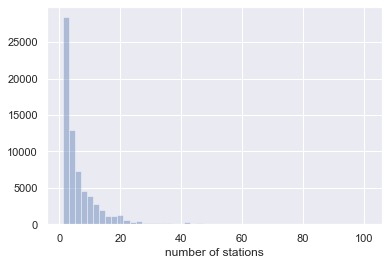

In [47]:
sns.distplot(circle_data.num, kde=False).set_xlabel("number of stations")

### The number of stations that reported Snow data (non-NaN stations per circle)

In [48]:
circle_data.num_notna.describe()

count    68390.000000
mean         0.866486
std          1.154033
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         30.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'number of non-NaN stations')

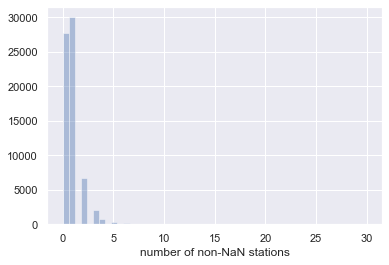

In [49]:
sns.distplot(circle_data.num_notna, kde=False).set_xlabel("number of non-NaN stations")

## Missing Stations

Text(0.5, 1.0, 'cumulative percent of stations missing')

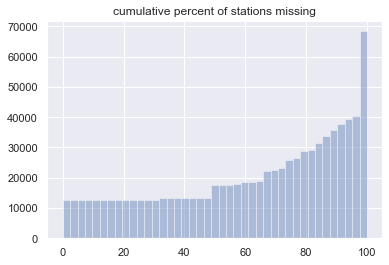

In [50]:
# Plot the number of stations (y-axis) agiast the proportion of stations missing rain data (x-axis)
sns.distplot((1 - circle_data.num_notna/circle_data.num) * 100, kde=False, hist_kws={'cumulative': True}).set_title('cumulative percent of stations missing')


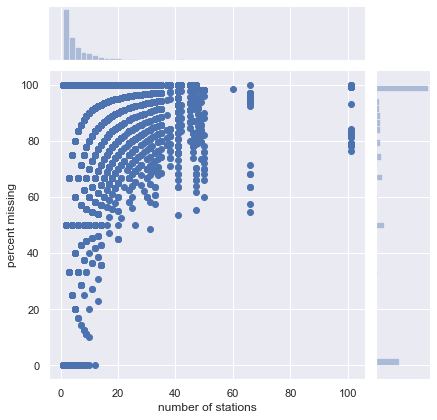

In [51]:
# Plot the relationship between the nuber of stations and the proportion of stations missing Rain data
sns.jointplot(circle_data.num, (1 - circle_data.num_notna/circle_data.num) * 100).set_axis_labels("number of stations", 'percent missing')

#### Percent of circles where all stations are missing data

In [52]:
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

40.67407515718672

In [53]:
circle_data.c_snow.value_counts(dropna = False)

NaN      42450
False    18305
True      7635
Name: c_snow, dtype: int64

#### Percent of circles where no stations are missing data

In [54]:
((circle_data.num_notna == circle_data.num) & (circle_data.num > 0)).sum() / len(circle_data) * 100

18.268752741628894

#### Percent of circles with less than half of stations missing ( Over half the stations reporting Snow Data

In [55]:
((circle_data.num_notna / circle_data.num) >= 0.5).sum() / len(circle_data) * 100

25.851732709460446

## The number of stations per circle broken down by ecosystem
The two ecosystems calssification are ecosystem (as defined by usgs) and nlcd code

The prefixes "e_" and "n_", which is same ecosystem and same nlcd code, respectfully

In [56]:
# The breakdown of stations with the same nlcd code 
circle_data.n_num.describe()

count    68390.000000
mean         2.174675
std          3.956987
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: n_num, dtype: float64

In [57]:
# The breakdown of stations with the same ecosystem
circle_data.e_num.describe()

count    68390.000000
mean         1.517225
std          2.816323
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         26.000000
Name: e_num, dtype: float64

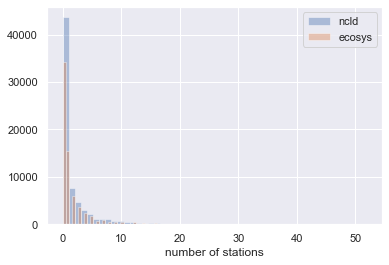

In [58]:
# The number of stations that share the same ncld or ecosys with their circle
sns.distplot(circle_data.n_num, kde=False)
ax = sns.distplot(circle_data.e_num, kde=False)
ax.set_xlabel("number of stations")
ax.legend(["ncld", "ecosys"])

### The number of stations with snow data in the same ecosystem classifical as the  circle

In [59]:
circle_data.n_num_notna.describe()

count    68390.000000
mean         0.483331
std          0.966960
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         30.000000
Name: n_num_notna, dtype: float64

In [60]:
circle_data.e_num_notna.describe()

count    68390.000000
mean         0.337681
std          0.728628
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         15.000000
Name: e_num_notna, dtype: float64

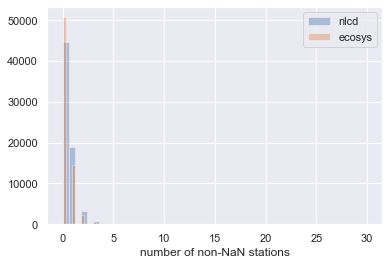

In [61]:
sns.distplot(circle_data.n_num_notna, kde=False)
ax = sns.distplot(circle_data.e_num_notna, kde=False)
ax.set_xlabel("number of non-NaN stations")
ax.legend(["nlcd", "ecosys"])

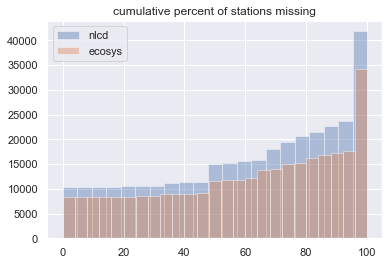

In [62]:
sns.distplot((1 - circle_data.n_num_notna/circle_data.n_num) * 100, kde=False, hist_kws={'cumulative': True})
ax = sns.distplot((1 - circle_data.e_num_notna/circle_data.e_num) * 100, kde=False, hist_kws={'cumulative': True})
ax.set_title('cumulative percent of stations missing')
ax.legend(["nlcd", "ecosys"])

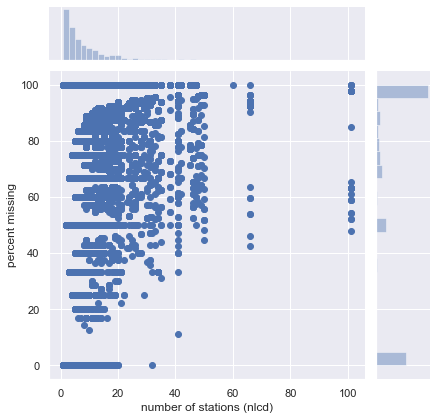

In [63]:
sns.jointplot(circle_data.num, (1 - circle_data.n_num_notna/circle_data.n_num) * 100).set_axis_labels("number of stations (nlcd)", 'percent missing')

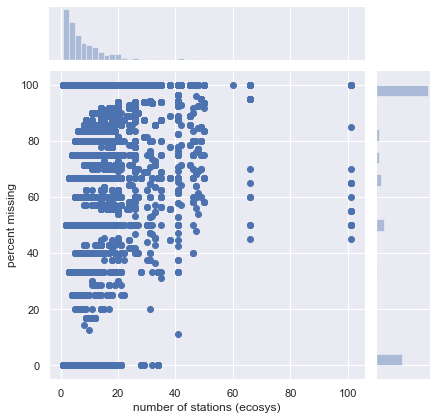

In [64]:
sns.jointplot(circle_data.num, (1 - circle_data.e_num_notna/circle_data.e_num) * 100).set_axis_labels("number of stations (ecosys)", 'percent missing')

#### Percent of circles where all stations are missing data

In [65]:
(circle_data.n_num_notna == 0).sum() / len(circle_data) * 100

65.17327094604475

In [66]:
(circle_data.e_num_notna == 0).sum() / len(circle_data) * 100

74.18189793829507

#### Percent of circles where no stations are missing data

In [67]:
((circle_data.n_num_notna == circle_data.n_num) & (circle_data.n_num > 0)).sum() / len(circle_data) * 100

15.250767656090073

In [68]:
((circle_data.e_num_notna == circle_data.e_num) & (circle_data.e_num > 0)).sum() / len(circle_data) * 100

12.203538529024712

#### Percent of circles with less than half of stations missing

In [69]:
((circle_data.n_num_notna / circle_data.n_num) >= 0.5).sum() / len(circle_data) * 100

22.02222547156017

In [70]:
((circle_data.e_num_notna / circle_data.e_num) >= 0.5).sum() / len(circle_data) * 100

17.00979675391139

## Location, Location, Location
The next section will focus in on the stations closest to the cbc circles by distance

#### What percent of circles had the closest station as NaN?

In [71]:
circle_data.snow_closest.isna().sum() / len(circle_data) * 100

69.76750986986401

#### What percent had the average value of the reference stations differ from the closest station's value (ignoring NaNs)?

In [72]:
# Use kleene logical indexing to skip over NAs
(circle_data.snow_closest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.016084222839596433

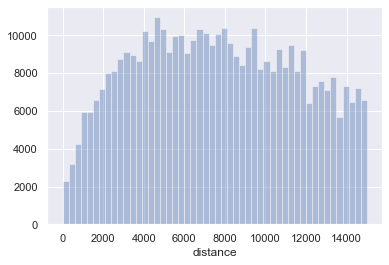

In [73]:
sns.distplot(prcp_data.distance, kde=False)

## Elevation, Elevation, Elevation
The next section will look at stations with the closest elivation

#### What percent of circles had the lowest station as NaN?

In [74]:
circle_data.snow_lowest.isna().sum() / len(circle_data) * 100

70.2061704927621

#### What percent had the average value differ from the lowest value (ignoring NaNs)?

In [75]:
# Use kleene logical indexing to skip over NAs
(circle_data.snow_lowest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.020470829068577275

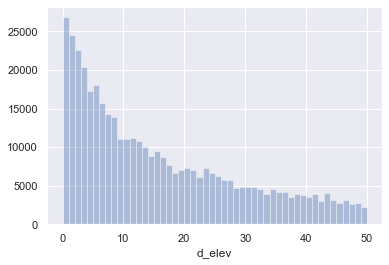

In [76]:
sns.distplot(prcp_data.d_elev, kde=False)

## Consensus of Stations
we use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for snow)

### All Stations

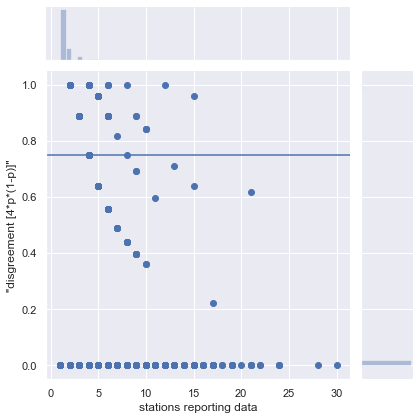

In [77]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p))
p.set_axis_labels("stations reporting data", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

### What percent do not meet our dissagreement threshold?

In [78]:
# Breaking this down a bit for easy of readability 

# circle_data.consensus is na when p (the proportion of staions for a circle reporting rain) is NA OR p is not 
# meeting the AGREEMENT Threshold 

# circle_data.p is NOT na when a circle has at least one station reporting rain data 

# PUTTING IT TOGETHER - The below line is the percent of circles who had at least one station 
# reporting but those stations could not agree
(circle_data.consensus.isna() & circle_data.p.notna()).sum() / len(circle_data) * 100

1.1843836818248281

### Ecosystems

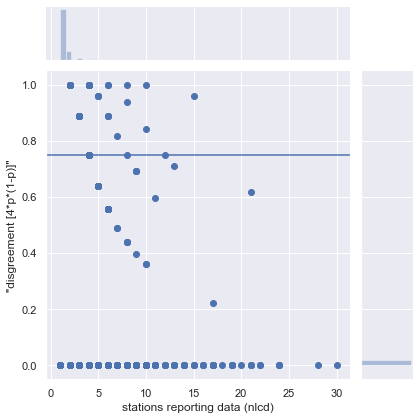

In [79]:
# Agreement Plot for Stations that share ncld codes with their circles 
p = sns.jointplot(circle_data.n_num_notna, 4 * circle_data.n_p * (1 - circle_data.n_p))
p.set_axis_labels("stations reporting data (nlcd)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

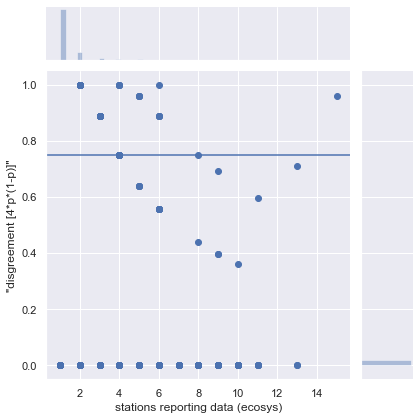

In [80]:
# Agreement Plot for Stations that share ecosys classification with their circles 
p = sns.jointplot(circle_data.e_num_notna, 4 * circle_data.e_p * (1 - circle_data.e_p))
p.set_axis_labels("stations reporting data (ecosys)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

#### What percent do not meet our dissagreement threshold?

In [81]:
# The below line counts the percentage of circles who had at least one station reporting with the same nlcd code
# but did not meet the agreement threshold
(circle_data.n_consensus.isna() & circle_data.n_p.notna()).sum() / len(circle_data) * 100

0.4752156748062582

In [82]:
# The below line counts the percentage of circles who had at least one station reporting with the same ecosys classifier
# but did not meet the agreement threshold
(circle_data.e_consensus.isna() & circle_data.e_p.notna()).sum() / len(circle_data) * 100

0.2953648194180436

### Consensus Breakdown by Circle Rain Reporting

In [87]:
# The number and percentage  of circles that reported Snow, No Snow or are NA 
print("The Count of Circles Reproting Snow:")
print(circle_data.c_snow.value_counts(dropna = False))
print("The Percentage of Circles Reproting Snow:")
print(circle_data.c_snow.value_counts(dropna = False, normalize = True) * 100)


The Count of Circles Reproting Snow:
NaN      42450
False    18305
True      7635
Name: c_snow, dtype: int64
The Percentage of Circles Reproting Snow:
NaN      62.070478
False    26.765609
True     11.163913
Name: c_snow, dtype: float64


#### Break Down of Concensus for Circles that reported True for Rain

In [88]:

print("Snow Data Consensus Amoung All Stations where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snow'] == True].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == True].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == True]) * 100))

print("Snow Data Amoung Closest Stations where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snow'] == True].snow_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == True].snow_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == True]) * 100))

print("Snow Data Amoung Closest in Elivation Stations where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snow'] == True].snow_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == True].snow_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snow'] == True].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == True].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same ecosys classification where the Circle Reported Snow:")
print(circle_data.loc[circle_data['c_snow'] == True].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == True].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == True]) * 100))




Snow Data Consensus Amoung All Stations where the Circle Reported Snow:
NaN      3782
False    2124
True     1729
Name: consensus, dtype: Int64
^^ with Percentage:
NaN      49.535036
False    27.819253
True     22.645711
Name: consensus, dtype: float64
Snow Data Consensus Amoung Closest Stations where the Circle Reported Snow:
NaN      5977
False     905
True      753
Name: snow_closest, dtype: Int64
^^ with Percentage:
NaN      78.284217
False    11.853307
True      9.862475
Name: snow_closest, dtype: float64
Snow Data Consensus Amoung Closest in Elivation Stations where the Circle Reported Snow:
NaN      6065
False     900
True      670
Name: snow_lowest, dtype: Int64
^^ with Percentage:
NaN      79.436804
False    11.787819
True      8.775377
Name: snow_lowest, dtype: float64
Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Reported Snow:
NaN      5416
False    1196
True     1023
Name: n_consensus, dtype: Int64
^^ with Percentage:
NaN      70.936477
False

#### Break Down of Concensus for Circles that reported False for Rain

In [91]:

print("Snow Data Consensus Amoung All Stations where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snow'] == False].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == False].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == False]) * 100))

print("Snow Data Amoung Closest Stations where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snow'] == False].snow_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == False].snow_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == False]) * 100))

print("Snow Data Amoung Closest in Elivation Stations where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snow'] == False].snow_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == False].snow_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == False]) * 100))

print("Snow Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snow'] == False].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == False].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == False]) * 100))

print("Snow Data Consensus Amoung Stations with the same ecosys classification where the Circle did NOT Report Snow:")
print(circle_data.loc[circle_data['c_snow'] == False].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['c_snow'] == False].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['c_snow'] == False]) * 100))




Snow Data Consensus Amoung All Stations where the Circle did NOT Report Snow:
False    9009
NaN      8515
True      781
Name: consensus, dtype: Int64
^^ with Percentage:
False    49.216061
NaN      46.517345
True      4.266594
Name: consensus, dtype: float64
Snow Data Consensus Amoung Closest Stations where the Circle did NOT Report Snow:
NaN      14555
False     3427
True       323
Name: snow_closest, dtype: Int64
^^ with Percentage:
NaN      79.513794
False    18.721661
True      1.764545
Name: snow_closest, dtype: float64
Snow Data Consensus Amoung Closest in Elivation Stations where the Circle did NOT Report Snow:
NaN      14328
False     3650
True       327
Name: snow_lowest, dtype: Int64
^^ with Percentage:
NaN      78.273696
False    19.939907
True      1.786397
Name: snow_lowest, dtype: float64
Snow Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Snow:
NaN      12378
False     5441
True       486
Name: n_consensus, dtype: Int64
^^ with Per

## The Missing Station and Circle Data

In [92]:
# Create a series indicating if a circle is missing weather data
circle_data_na_circle_idx = circle_data.c_snow.isna()

### Percent of circles with missing snow observation

In [93]:
circle_data_na_circle_idx.sum() / len(circle_data) * 100

62.070478140078954

### Count of circles with missing snow observation

In [94]:
print("Circles with missing Snow Data: ")
print(circle_data_na_circle_idx.sum())
print("Circles with NO missing Snow Data: ")
print(len(circle_data) - circle_data_na_circle_idx.sum())

Circles with missing Snow Data: 
42450
Circles with NO missing Snow Data: 
25940


### Percent of circles with both volunteer and all station data are missing

In [95]:
# joint
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / len(circle_data) * 100

23.402544231612808

In [96]:
# conditional 
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / circle_data_na_circle_idx.sum() * 100

37.70318021201414

In [97]:
# population
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

40.67407515718672

## Correlation between the two

In [98]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna == 0))
g, p

(409.04235366458045, 5.923550141181931e-91)

if the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

#### Count and Percent of Stations Reporting if the Circle Reported Snow Data

In [99]:
print("Stations with missing Snow Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Stations with NO missing Snow Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Stations with missing Snow Data IF the the Circle is Reporting:
11812
45.535851966075555
Stations with NO missing Snow Data IF the Circle is Reporting: 
14128
54.464148033924445


### Percent of circles with both volunteer and the closest station data are missing

In [100]:
# joint
(circle_data_na_circle_idx & circle_data.snow_closest.isna()).sum()  / len(circle_data) * 100

39.74557683871911

In [101]:
# conditional 
(circle_data_na_circle_idx & circle_data.snow_closest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

64.03297997644287

In [102]:
# population
circle_data.snow_closest.isna().sum() / len(circle_data) * 100

69.76750986986401

In [103]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.snow_closest.isna()))
g, p

(1744.1763855536212, 0.0)

if the circle is missing data, it is much **less** likely that the closest station will have missing data, when compared to the general population

#### Count and Percent of Closest Stations Reporting if the Circle Reported Snow Data

In [114]:
print("Closest Stations with missing Snow Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Stations with NO missing Snow Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Stations with missing Snow Data IF the the Circle is Reporting:
20532
79.15188897455667
Closest Stations with NO missing Snow Data IF the Circle is Reporting: 
5408
20.84811102544333


### Percent of circles with both volunteer and the lowest station data are missing

In [115]:
# joint
(circle_data_na_circle_idx & circle_data.snow_lowest.isna()).sum()  / len(circle_data) * 100

40.38748355022664

In [116]:
# conditional 
(circle_data_na_circle_idx & circle_data.snow_lowest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

65.06713780918729

In [117]:
# population
circle_data.snow_lowest.isna().sum() / len(circle_data) * 100

70.2061704927621

In [118]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.snow_lowest.isna()))
g, p

(1412.4151644159392, 4.2130431115998e-309)

if the circle is missing data, it is much **less** likely that the lowest station will have missing data, when compared to the general population

#### Count and Percent of Closest Elivation Stations Reporting if the Circle Reported Rain Data

In [119]:
print("Closest Elivation Stations with missing Snow Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.snow_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Elivation Stations with NO missing Snow Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.snow_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Elivation Stations with missing Snow Data IF the the Circle is Reporting:
20393
78.61603700848111
Closest Elivation Stations with NO missing Snow Data IF the Circle is Reporting: 
5547
21.38396299151889


### Number of stations for circles with missing data

In [120]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(780.9181069474313, 1.2753540324569464e-148)

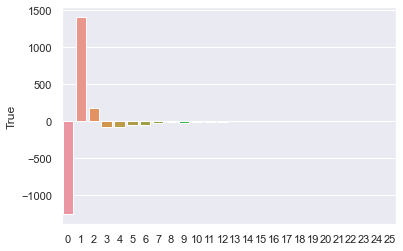

In [121]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### Disagreement

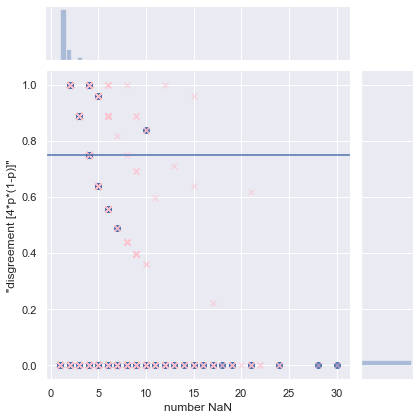

In [122]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.loc[circle_data_na_circle_idx, 'num_notna'], 
                  4 * circle_data.loc[circle_data_na_circle_idx, 'p'] * (1 - circle_data.loc[circle_data_na_circle_idx, 'p']))
p.ax_joint.scatter(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

### What percent do not meet our dissagreement threshold?

In [123]:
# joint
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / len(circle_data) * 100

23.877759906419065

In [124]:
# conditional
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / circle_data_na_circle_idx.sum() * 100

38.468786808009426

In [125]:
# population
circle_data.consensus.isna().sum() / len(circle_data) * 100

41.858458839011554

In [126]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.consensus.isna())
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(528.0123000722955, 7.645136478036099e-117)

In [127]:
actl - expctd

consensus,False,True
c_snow,,
False,-1438.915777,1438.915777
True,1438.915777,-1438.915777


Missing your snow data imples the stations are more likely to consense

# The Truth: Reference Stations Vs Other Reference Station Data

This just station data all by itself (station data vs station data)

Testing to see if there is that much difference between the "truth" from the different station metrics (ie, consensus, consensus amongst the same ecosystem)

How often does it snow?

In [128]:
circle_data.consensus.sum()/ circle_data.consensus.count()

0.1037396574705128

### Location & Consensus

In [129]:
# Cross tabs of the closest station to a circle vs the consenting stations 
pd.crosstab(circle_data.consensus, circle_data.snow_closest_notna)

snow_closest_notna,False,True
consensus,,
False,35634,4
True,7,4118


In [130]:
# Cross tabs of the closest station in elivation to a circle vs the consenting stations 
pd.crosstab(circle_data.consensus, circle_data.snow_lowest_notna)

snow_lowest_notna,False,True
consensus,,
False,35520,6
True,8,4071


In [131]:
# Cross tabs of the closest station to a circle vs the station with the closest elivation
pd.crosstab(circle_data.snow_closest_notna, circle_data.snow_lowest_notna)

snow_lowest_notna,False,True
snow_closest_notna,,
False,35752,161
True,162,4337


### Ecosystem Consensus

In [132]:
# Crosstable of stations with consensus vs stations with nlcd consensus 
pd.crosstab(circle_data.consensus, circle_data.n_consensus)

n_consensus,False,True
consensus,,
False,20927,0
True,1,2317


In [133]:
# Crosstabs  of stations with consensus vs stations with ecosys consensus
pd.crosstab(circle_data.consensus, circle_data.e_consensus)

e_consensus,False,True
consensus,,
False,15477,0
True,1,1731


In [134]:
pd.crosstab(circle_data.n_consensus, circle_data.e_consensus)

e_consensus,False,True
n_consensus,,
False,15554,0
True,0,1824


 ### Did just one station see rain?

In [135]:
# Cross tabes of the rain reported by the closest station and if any reference station said it rained
pd.crosstab(circle_data.snow_closest_notna, circle_data.num_true > 0)

num_true,False,True
snow_closest_notna,,
False,35611,414
True,0,4548


In [136]:
# Crosstabs of the rain reported by the closest station in elivation and if any reference station said it rained
pd.crosstab(circle_data.snow_lowest_notna, circle_data.num_true > 0)

num_true,False,True
snow_lowest_notna,,
False,35499,415
True,0,4498


In [137]:
# Crosstabs of the stations resporting consensus vs ANY reference station that reported rain
pd.crosstab(circle_data.consensus, circle_data.num_true > 0)

num_true,False,True
consensus,,
False,35611,27
True,0,4125


In [138]:
# Crosstabs of the stations resporting consensus vs ANY NLCD MATCHING reference station that reported rain
pd.crosstab(circle_data.consensus, circle_data.n_num_true > 0)

n_num_true,False,True
consensus,,
False,35617,21
True,1804,2321


In [139]:
# Crosstabs of the stations resporting consensus vs ANY ECOSYS MATCHING reference station that reported rain
pd.crosstab(circle_data.consensus, circle_data.e_num_true > 0)

e_num_true,False,True
consensus,,
False,35624,14
True,2387,1738


# Circle v Station: The Final Determination on If Volenteers are Reliable

In [140]:
def crosstab_metrics(actl):
    # accuracy
    acc = actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()
    # precision
    pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
    # recall
    re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
    # F1
    f1 = 2 * pr * re / (pr + re)
    
    print(f"accuracy:  {acc*100:.2f}%")
    print(f"precision: {pr*100:.2f}%")
    print(f"recall:    {re*100:.2f}%")
    print(f"F1:        {f1*100:.2f}%")
    
#     return (acc, pr, re, f1)

### Based on the stations' consensus

In [141]:
actl = pd.crosstab(circle_data.consensus, circle_data.c_snow)
actl

c_snow,False,True
consensus,,
False,9009,2124
True,781,1729


In [142]:
crosstab_metrics(actl)

accuracy:  78.71%
precision: 44.87%
recall:    68.88%
F1:        54.35%


### Based on the closest station

In [143]:
actl = pd.crosstab(circle_data.snow_closest_notna, circle_data.c_snow)
actl

c_snow,False,True
snow_closest_notna,,
False,9124,2249
True,886,1869


In [144]:
crosstab_metrics(actl)

accuracy:  77.81%
precision: 45.39%
recall:    67.84%
F1:        54.39%


### Based on the closest station in elivation

In [145]:
actl = pd.crosstab(circle_data.snow_lowest_notna, circle_data.c_snow)
actl

c_snow,False,True
snow_lowest_notna,,
False,9076,2230
True,888,1842


In [146]:
crosstab_metrics(actl)

accuracy:  77.79%
precision: 45.24%
recall:    67.47%
F1:        54.16%


### Based on the nlcd consensus

In [147]:
actl = pd.crosstab(circle_data.n_consensus, circle_data.c_snow)
actl

c_snow,False,True
n_consensus,,
False,5441,1196
True,486,1023


In [148]:
crosstab_metrics(actl)

accuracy:  79.35%
precision: 46.10%
recall:    67.79%
F1:        54.88%


### Based on the ecosys consensus

In [149]:
actl = pd.crosstab(circle_data.e_consensus, circle_data.c_snow)
actl

c_snow,False,True
e_consensus,,
False,4061,876
True,397,780


In [150]:
crosstab_metrics(actl)

accuracy:  79.18%
precision: 47.10%
recall:    66.27%
F1:        55.07%


### Did at least one station aggree?

In [151]:
actl = pd.crosstab(circle_data.num_true >= 1, circle_data.c_snow)
actl

c_snow,False,True
num_true,,
False,17291,5630
True,1014,2005


In [152]:
crosstab_metrics(actl)

accuracy:  74.39%
precision: 26.26%
recall:    66.41%
F1:        37.64%
